In [32]:
import os
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch import device
from torch.utils.data import DataLoader

# this part is something have my fault, acc is soo low a nd book have a lot of mistakes.
# ex) for idx ... => some[i]

In [33]:
data_path = "../data/cat_and_dog/train"

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, num_workers=8, shuffle=True)

print("CUDA is available : ", torch.cuda.is_available())
print("GPU count : ", torch.cuda.device_count())
for gpu in range(torch.cuda.device_count()):
    print("GPU name : ", torch.cuda.get_device_name(gpu))
print("Length of train_dataset : ", len(train_dataset))


CUDA is available :  True
GPU count :  1
GPU name :  NVIDIA GeForce RTX 3060 Laptop GPU
Length of train_dataset :  8005


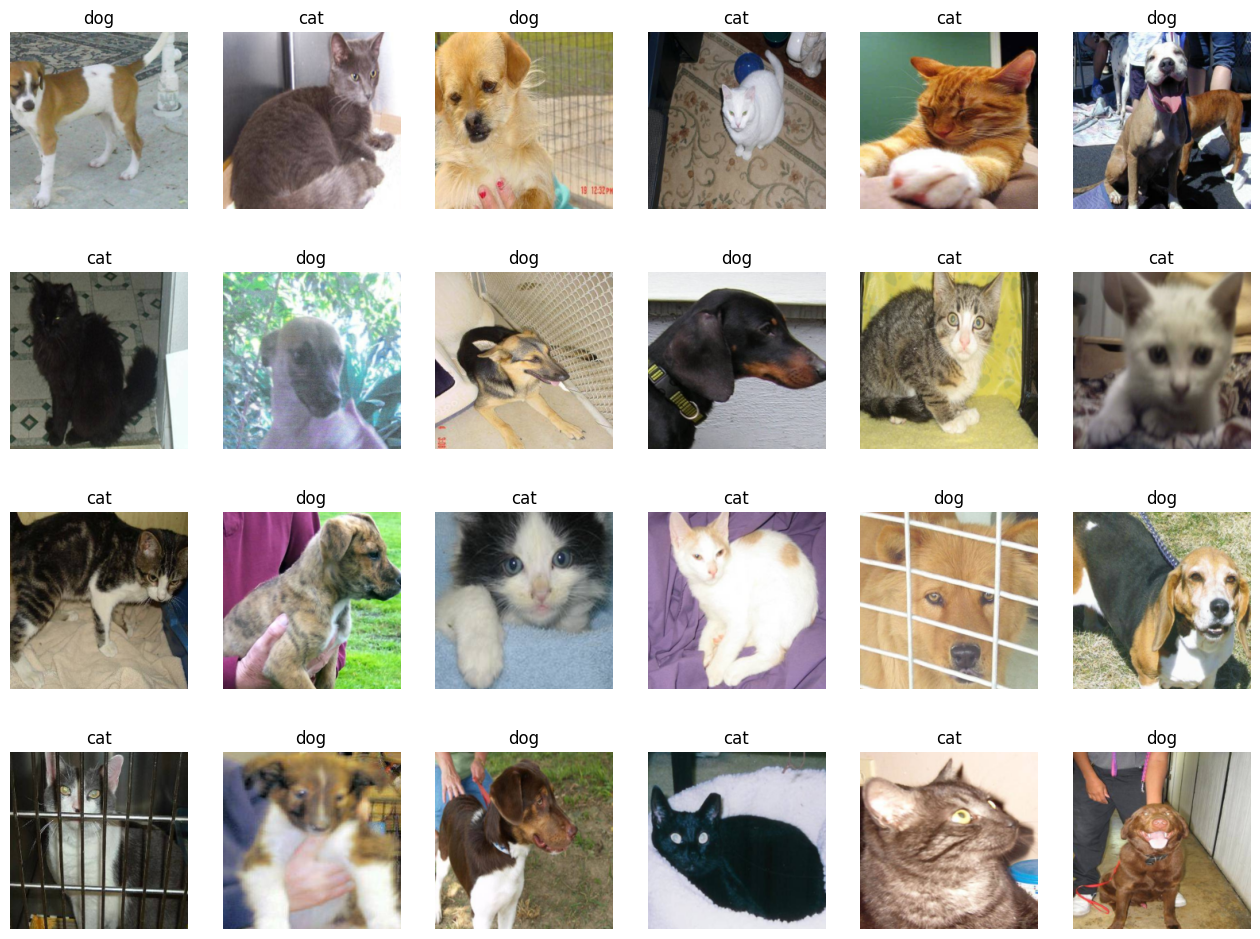

In [34]:
samples, labels = next(iter(train_loader))
classes = {0: "cat", 1: "dog"}
fig = plt.figure(figsize=(16, 24))

for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

resnet = models.resnet18(pretrained=True)


def set_parameter_requires_grad(_model, feature_extract=True):
    if feature_extract:
        for _param in _model.parameters():
            _param.requires_grad = False


set_parameter_requires_grad(resnet)

In [35]:
resnet.fc = nn.Linear(512, 2)

for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name, param.data)

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters())
cost = nn.CrossEntropyLoss()

print(model)


def train_model(mod, dataloaders, crit, opti, _device, num_epochs=13):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs_, labels_ in dataloaders:
            inputs_, labels_ = inputs_.to(_device), labels_.to(_device)

            mod.to(_device)
            opti.zero_grad()
            outputs = mod(inputs_)
            loss = crit(outputs, labels_)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            opti.step()

            running_loss += loss.item() * inputs_.size(0)
            running_corrects += torch.sum(preds == labels_.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print("Loss : {:.5f} Acc : {:.5f}".format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        if not os.path.isdir("../data/model"):
            os.mkdir("../data/model")

        torch.save(mod.state_dict(), os.path.join("../data/model", "{0:0=2d}.pth".format(epoch)))
        print()

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc : {:.5f}".format(best_acc))
    return acc_history, loss_history

fc.weight tensor([[ 0.0350,  0.0099,  0.0042,  ..., -0.0432,  0.0126,  0.0093],
        [-0.0330,  0.0047,  0.0062,  ..., -0.0394,  0.0094,  0.0141]])
fc.bias tensor([-0.0153,  0.0091])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kerne

In [36]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print("\t", name)

device = device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet, train_loader, criterion, optimizer, device)

test_path = "../data/cat_and_dog/test"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=1, shuffle=True)

print("Length of test_dataset : ", len(test_dataset))


def eval_model(mod, dataloaders, _device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = [path.replace("\\", "/") for path in glob("../data/model/*.pth")]
    saved_models.sort()
    print("Saved models : ", saved_models)

    for model_path in saved_models:
        print("Load model : ", model_path)

        mod.load_state_dict(torch.load(model_path))
        mod.eval()
        mod.to(_device)
        running_corrects = 0

        for inputs, _labels in dataloaders:
            inputs, _labels = inputs.to(_device), _labels.to(_device)

            with torch.no_grad():
                outputs = mod(inputs)

            _, preds = torch.max(outputs, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(_labels.data.view_as(preds)).sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print("Acc : {:.5f}".format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print("Eval complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc : {:.5f}".format(best_acc))

    return acc_history

	 fc.weight
	 fc.bias
Epoch 0/12
----------
Loss : 0.78937 Acc : 0.49719

Epoch 1/12
----------
Loss : 0.78924 Acc : 0.49482

Epoch 2/12
----------
Loss : 0.79247 Acc : 0.50119

Epoch 3/12
----------
Loss : 0.79106 Acc : 0.50044

Epoch 4/12
----------
Loss : 0.79148 Acc : 0.49469

Epoch 5/12
----------
Loss : 0.79022 Acc : 0.50031

Epoch 6/12
----------
Loss : 0.79036 Acc : 0.49669

Epoch 7/12
----------
Loss : 0.79147 Acc : 0.50493

Epoch 8/12
----------
Loss : 0.78964 Acc : 0.49956

Epoch 9/12
----------
Loss : 0.78986 Acc : 0.49644

Epoch 10/12
----------
Loss : 0.78915 Acc : 0.49557

Epoch 11/12
----------
Loss : 0.79109 Acc : 0.49919

Epoch 12/12
----------
Loss : 0.78930 Acc : 0.50356

Training complete in 6m 29s
Best Acc : 0.50493
Length of test_dataset :  2023


Saved models :  ['../data/model/00.pth', '../data/model/01.pth', '../data/model/02.pth', '../data/model/03.pth', '../data/model/04.pth', '../data/model/05.pth', '../data/model/06.pth', '../data/model/07.pth', '../data/model/08.pth', '../data/model/09.pth', '../data/model/10.pth', '../data/model/11.pth', '../data/model/12.pth']
Load model :  ../data/model/00.pth
Acc : 0.48690

Load model :  ../data/model/01.pth
Acc : 0.49580

Load model :  ../data/model/02.pth
Acc : 0.48542

Load model :  ../data/model/03.pth
Acc : 0.49184

Load model :  ../data/model/04.pth
Acc : 0.48245

Load model :  ../data/model/05.pth
Acc : 0.48047

Load model :  ../data/model/06.pth
Acc : 0.49481

Load model :  ../data/model/07.pth
Acc : 0.48542

Load model :  ../data/model/08.pth
Acc : 0.48888

Load model :  ../data/model/09.pth
Acc : 0.49184

Load model :  ../data/model/10.pth
Acc : 0.47257

Load model :  ../data/model/11.pth
Acc : 0.48987

Load model :  ../data/model/12.pth
Acc : 0.48542

Eval complete in 2m 3

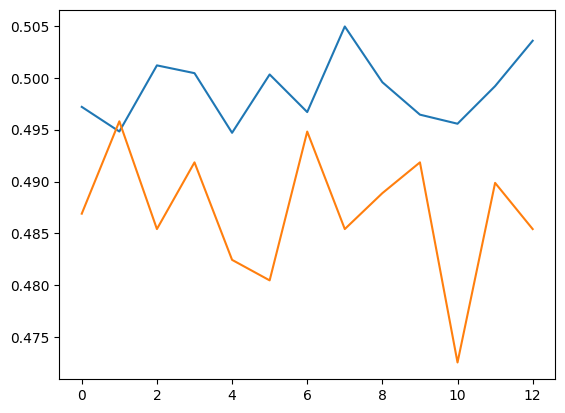

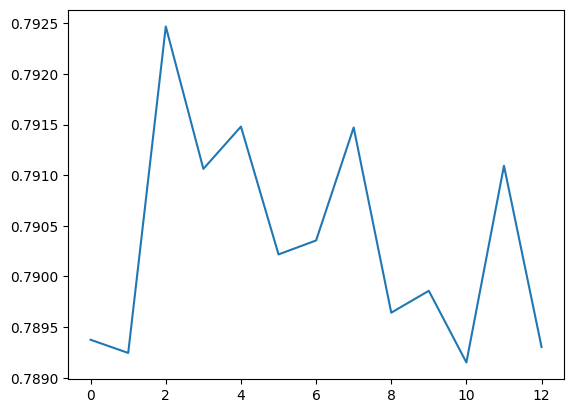

In [37]:
val_acc_hist = eval_model(resnet, test_loader, device)

plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Test Acc")
plt.show()

plt.plot(train_loss_hist, label="Train Loss")
plt.show()

In [38]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

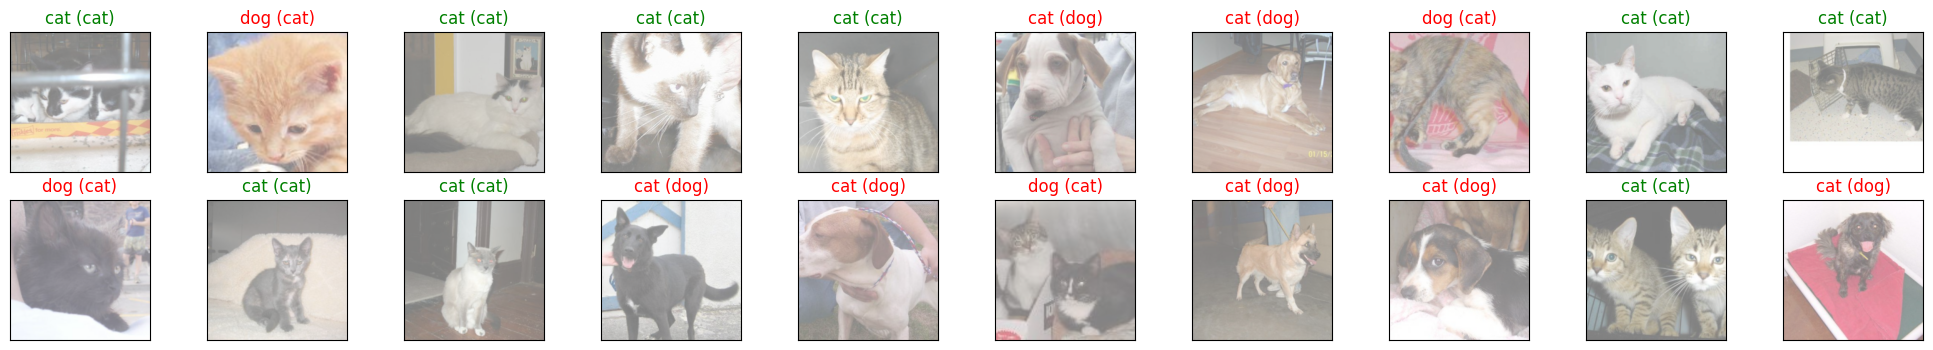

<Figure size 640x480 with 0 Axes>

In [39]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
             color=("green" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)